# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [2]:
import torch
import numpy as np
import hydra
import copy
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [3]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=clsattack'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [436]:
with open_dict(cfg):
    cfg.case.data.partition = "unique-class"
    cfg.case.user.user_idx = 9
    cfg.case.user.num_data_points = 8
    cfg.case.model = 'resnet18'
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True

    cfg.attack.optim.max_iterations = 24000

### Instantiate all parties

In [437]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of       9:1 for target shape [8, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 8

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 9
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponen

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [438]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 1
how_many_rec = 1

# preparing for the attack
server.reset_model()
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

t_labels = true_user_data['labels'].cpu().detach().numpy()
cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}
all_feature = torch.flatten(server.reconstruct_feature(shared_data, cls_to_obtain))

server.reset_model()
server.reconfigure_model('cls_attack', extra_info=extra_info)
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
avg_feature = torch.flatten(server.reconstruct_feature(shared_data, cls_to_obtain))
other_feature = avg_feature - all_feature

single_gradient_recovered = False
user.counted_queries = 0

while not single_gradient_recovered:
    feat_to_obtain = int(torch.argmax(avg_feature))
    feat_value = float(avg_feature[feat_to_obtain])

    # binary attack to recover all single gradients
    extra_info["feat_to_obtain"] = feat_to_obtain
    extra_info["feat_value"] = feat_value
    extra_info["multiplier"] = 1
    extra_info["num_target_data"] = int(torch.count_nonzero((shared_data["metadata"]["labels"] == int(cls_to_obtain)).to(int)))
    extra_info["num_data_points"] = int(cfg.case.user.num_data_points)
    
    recovered_single_gradients = server.binary_attack(user, extra_info)
    # recovered_single_gradients = server.one_shot_binary_attack(user, extra_info)
    if recovered_single_gradients is not None:
        single_gradient_recovered = True
    else:
        avg_feature[feat_to_obtain] = -1000

    logger.info(f"Spent {user.counted_queries} user queries so far.")

# reorder the gradients
server.reset_model()
extra_info['multiplier'] = 1
extra_info['feat_value'] = feat_value
extra_info["feat_to_obtain"] = feat_to_obtain
server.reconfigure_model('cls_attack', extra_info=extra_info)
server.reconfigure_model('feature_attack', extra_info=extra_info)
server_payload = server.distribute_payload()

target_indx = np.where(t_labels == cls_to_obtain)
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][target_indx]
tmp_true_user_data['labels'] = true_user_data['labels'][target_indx]

attacker.objective.cfg_impl = cfg.attack.impl
single_gradients, single_losses = server.cal_single_gradients(attacker, tmp_true_user_data)
recovered_single_gradients = server.order_gradients(recovered_single_gradients, single_gradients)

Too many attempts (24) on this feature!
Spent 24 user queries so far.
Too many attempts (24) on this feature!
Spent 48 user queries so far.
Spent 67 user queries so far.


In [439]:
for i in range(len(recovered_single_gradients)):
    grad_0 = torch.cat([torch.flatten(ii) for ii in recovered_single_gradients[i]])
    grad_0_0 = single_gradients[i]
    
    print(float(torch.nn.CosineSimilarity(dim=0)(grad_0, grad_0_0).detach()))

0.9650693535804749
0.9460054636001587
0.9713162183761597
0.9702017903327942
0.969352662563324
0.9583032727241516
0.9684286713600159
0.9547781348228455


In [15]:
server.reset_model()
extra_info['multiplier'] = 1
extra_info['feat_value'] = feat_value
server.reconfigure_model('cls_attack', extra_info=extra_info)
server.reconfigure_model('feature_attack', extra_info=extra_info)

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

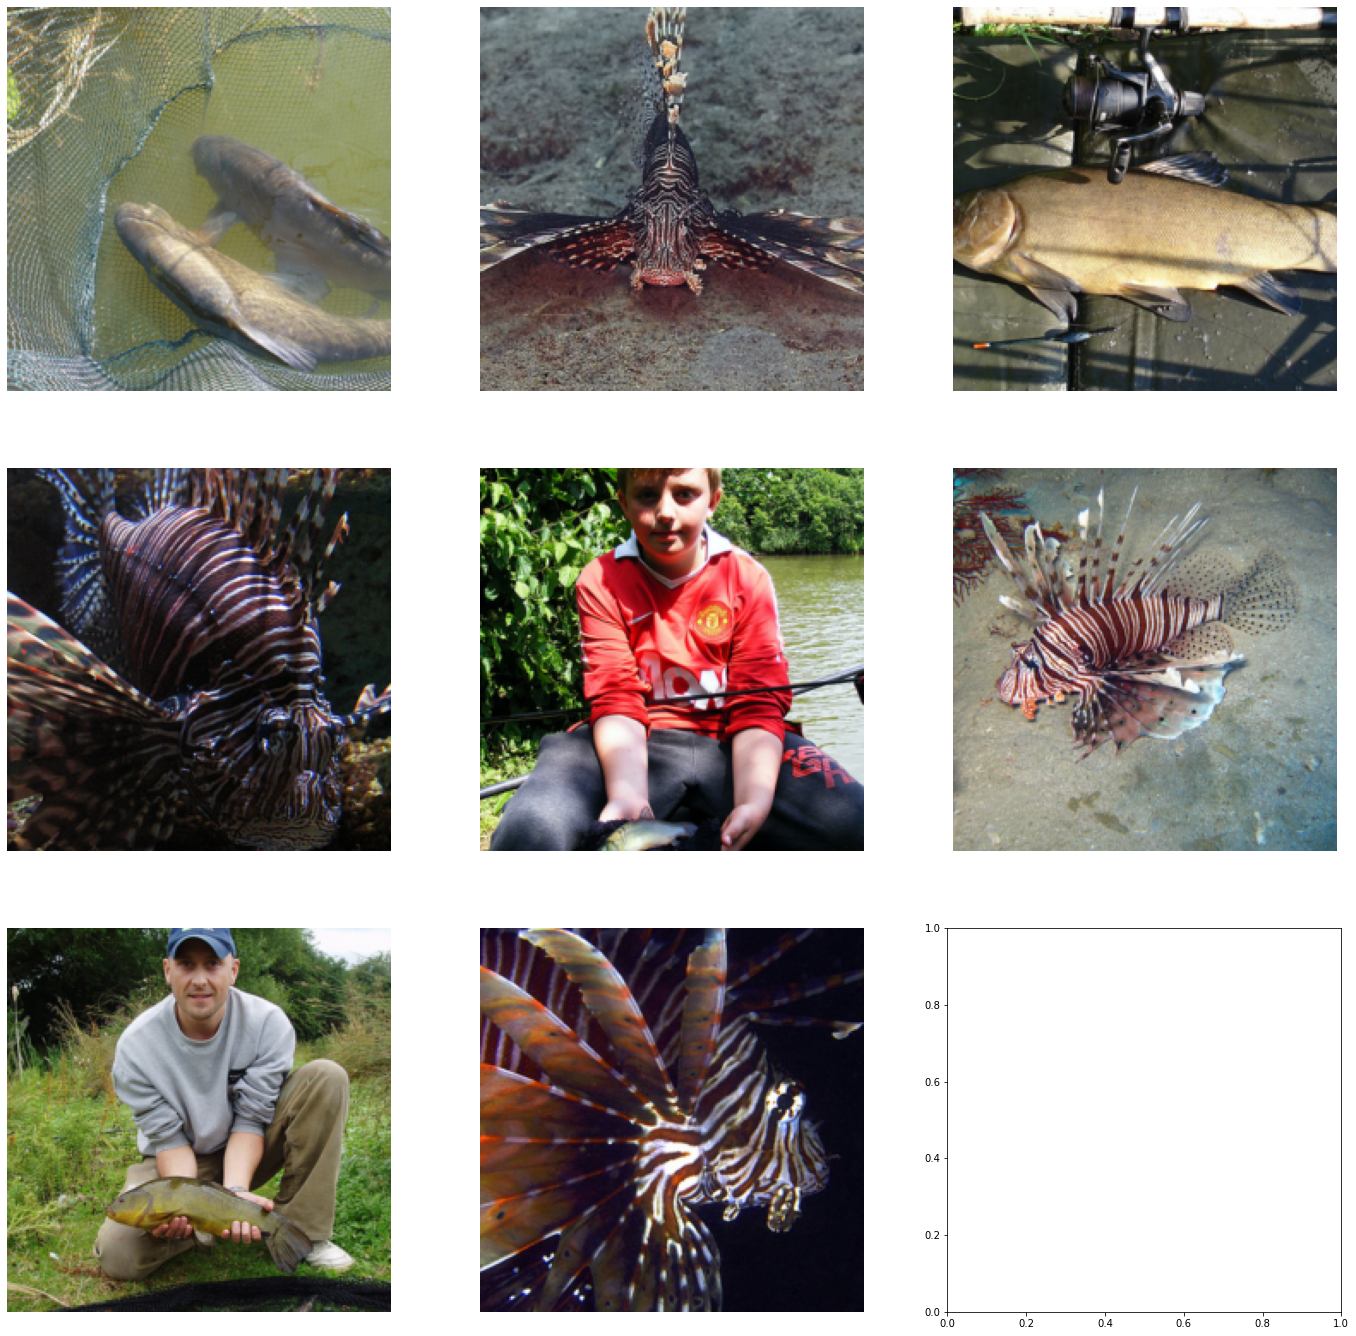

In [16]:
user.plot(true_user_data)

### Reconstruct user data:

In [142]:
tmp_share_data = copy.deepcopy(shared_data)
tmp_share_data['metadata']['num_data_points'] = how_many_rec
tmp_share_data['metadata']['labels'] = shared_data['metadata']['labels'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_share_data['gradients'] = recovered_single_gradients[which_to_recover]
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data['labels'] = true_user_data['labels'][which_to_recover:(which_to_recover + how_many_rec)]

In [143]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [tmp_share_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

Optimal candidate solution with rec. loss 0.9453 selected.


In [144]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.1746 | PSNR: 7.58 | FMSE: 7.3363e+00 | LPIPS: 1.09|
 R-PSNR: 8.14 | IIP-pixel: 0.00% | SSIM: 0.0748 | max R-PSNR: 8.14 | max SSIM: 0.0748 | Label Acc: 100.00%


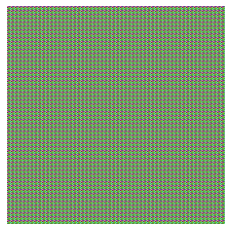

In [145]:
user.plot(reconstructed_user_data)

In [426]:
# server.reset_model()
# extra_info['multiplier'] = 1000
# extra_info["db_flip"] = 1
# extra_info['feat_value'] = server.all_feat_value[1]
# server.reconfigure_model('cls_attack', extra_info=extra_info)
# server.reconfigure_model('feature_attack', extra_info=extra_info)
# server_payload = server.distribute_payload()
# shared_data, true_user_data = user.compute_local_updates(server_payload) 

# attacker.objective.cfg_impl = cfg.attack.impl
# single_gradients, single_losses = server.cal_single_gradients(attacker, true_user_data)
# server.print_gradients_norm(single_gradients, single_losses)

grad norm         loss
0.0 0.0
0.0 0.0
140533.5 229.55905151367188
192775.453125 1029.668701171875


In [411]:
# server.all_feat_value

array([4.23699474, 4.86062717, 5.48425961, 6.35030699])